# Figure 2a. Number of interactions in different parsing modes

Pairtools parse starts from .bam files and convert them to .pairs, it can work in several parsing modes. 

Here, we will take the data from several Hi-C and Micro-C datasets, map them with `distiller-nf` and get the number of reads from them depending on the parsing modes.

The whole dataset after processing weights a couple of Tbs, and we post a small example of how the data was processed. 

## Data download and pre-processing

0. GEO indexes of data to be analysed: 

|           Paper    | GEO ID    | Species/assembly | Read length | Protocol |
|--------------------|-----------|------------------|-------------|----------|
| Rao et al. 2017    | GSE104333 | human / hg38     |    150 bp   | Hi-C     | 
| Hansen et al. 2021 | GSE178982 | mouse / mm10     | 151 bp      | Micro-C  |
| Du et al. 2021     | GSE158007 | human / hg38     |  149 bp     | Hi-C     |
| Mitter et al. 2020 | GSE152373 | human / hg38     |   250 bp    | scsHi-C  |


1. Git clone distiller,  isntall the dependencies, run `bin/geo2yml.py` on the GEO indexes. 
Select only relevant datasets

2. Run distiller mapping on the appropriate genomes (or only `bwa mem`).

3. Parse `.bam` files in four modes:


In [15]:
### Prepare the genome:
import bioframe

hg38_chromsizes = bioframe.fetch_chromsizes('hg38', as_bed=True)
hg38_cens = bioframe.fetch_centromeres('hg38')
hg38_arms = bioframe.make_chromarms(hg38_chromsizes, hg38_cens, cols_chroms=hg38_chromsizes.columns)

hg38_chromsizes[['chrom', 'end']].to_csv('./data/hg38.reduced.chrom.sizes', sep='\t', header=False, index=False)
hg38_arms.to_csv("./data/hg38.arms.viewframe.tsv", sep='\t', header=True, index=False)

In [ ]:
%%bash
# Download test data from OSF (todo: upload it there): 
mkdir data/ 
wget Mitter_HIC_G2.lane1.sample.bam -P ./data/
wget hg38.reduced.chrom.sizes -P ./data/

In [ ]:
%%bash
file="./data/Mitter_HIC_G2.lane1.sample.bam"
pairtools parse $file -c ./data/hg38.reduced.chrom.sizes -o $file.parse-all.pairs --walks-policy all
pairtools parse $file -c ./data/hg38.reduced.chrom.sizes -o $file.parse-mask.pairs --walks-policy mask
pairtools parse $file -c ./data/hg38.reduced.chrom.sizes -o $file.parse-5any.pairs --walks-policy 5any
pairtools parse2 $file -c ./data/hg38.reduced.chrom.sizes -o $file.parse2-expanded.pairs --expand

4. Run `pairtools stat` and `samtools flagstat` to determine the number of reads:

In [ ]:
%%bash
file="./data/Mitter_HIC_G2.lane1.sample.bam"
pairtools stats $file.parse-all.pairs -o $file.parse-all.stats
pairtools stats $file.parse-mask.pairs -o $file.parse-mask.stats
pairtools stats $file.parse-5any.pairs -o $file.parse-5any.stats
pairtools stats $file.parse2-expanded.pairs -o $file.parse2-expanded.stats

In [ ]:
%%bash
file="./data/Mitter_HIC_G2.lane1.sample.bam"
samtools flagstat -@20 $file > $file.flagstat.txt

5. Calculate genomic scalings: 

In [ ]:
%%bash
file="./data/Mitter_HIC_G2.lane1.sample.bam"
pairtools scaling $file.parse-all.pairs -o ${file}.parse-all.scaling.txt --view ./data/hg38.arms.viewframe.tsv 
pairtools scaling $file.parse-mask.pairs -o ${file}.parse-mask.scaling.txt --view ./data/hg38.arms.viewframe.tsv 
pairtools scaling $file.parse-5any.pairs -o ${file}.parse-5any.scaling.txt --view ./data/hg38.arms.viewframe.tsv 
pairtools scaling $file.parse2-expanded.pairs -o ${file}.parse2-expanded.scaling.txt --view ./data/hg38.arms.viewframe.tsv 

## View the results

In [12]:
!head -n 10 ./data/Mitter_HIC_G2.lane1.sample.bam.parse-all.stats

total	4627
total_unmapped	310
total_single_sided_mapped	912
total_mapped	3405
total_dups	0
total_nodups	3405
cis	3150
trans	255
pair_types/UU	3405
pair_types/NU	492


In [13]:
!head -n 10 ./data/Mitter_HIC_G2.lane1.sample.bam.flagstat.txt

9544 + 0 in total (QC-passed reads + QC-failed reads)
0 + 0 secondary
1747 + 0 supplementary
0 + 0 duplicates
9513 + 0 mapped (99.68% : N/A)
7797 + 0 paired in sequencing
3899 + 0 read1
3898 + 0 read2
0 + 0 properly paired (0.00% : N/A)
7739 + 0 with itself and mate mapped


In [15]:
!head -n 10 ./data/Mitter_HIC_G2.lane1.sample.bam.parse-all.scaling.txt

	chrom1	start1	end1	chrom2	start2	end2	strand1	strand2	min_dist	max_dist	n_pairs	n_bp2	np_bp2
0	!	-1	-1	!	-1	-1	+	-	0.0	10.0	74	0.0	
1	!	-1	-1	!	-1	-1	-	+	0.0	10.0	98	0.0	
2	!	-1	-1	!	-1	-1	-	-	0.0	10.0	138	0.0	
3	chr1	0	123479591	chr1	0	123479591	+	+	0.0	10.0	0	1234795860.0	
4	chr1	0	123479591	chr1	0	123479591	+	+	10.0	12.0	0	246959160.0	
5	chr1	0	123479591	chr1	0	123479591	+	+	12.0	13.0	0	123479578.0	
6	chr1	0	123479591	chr1	0	123479591	+	+	13.0	15.0	0	246959154.0	
7	chr1	0	123479591	chr1	0	123479591	+	+	15.0	18.0	0	370438724.0	
8	chr1	0	123479591	chr1	0	123479591	+	+	18.0	21.0	0	370438714.0	


## Plot the results for four papers

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
import seaborn as sns
import seaborn.objects as so # requires seaborn > 0.12.1 
from seaborn import axes_style
from matplotlib import style

import numpy as np
import pandas as pd
import statsmodels.api as sm
from scipy import stats

import glob

In [2]:
df = pd.DataFrame()
for file in glob.glob("unmerged/*.stats"):
    df_tmp = pd.read_table(file, header=None).set_index(0).T.reset_index(drop=True)
    
    try:
        df_tmp1 = pd.read_table(file.split('.bam')[0]+'.bam.flagstat', sep=' \+ 0 ', header=None, engine='python').set_index(1).T.reset_index(drop=True)
        df_tmp = pd.concat([df_tmp, df_tmp1], axis=1)
    except Exception as e:
        pass
    
    df_tmp.loc[:, "file"] = file.split('/')[-1]
    
    df = pd.concat([df, df_tmp], axis=0)

In [3]:
df.loc[:, 'parser'] = df.file.str.split('.').str[-3]
df.loc[:, 'dataset'] = df.file.str.split('.').str[0]
df.loc[:, 'chunk'] = df.file.str.split('.').str[3]

/tmp/ipykernel_22652/3668541393.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.loc[:, 'parser'] = df.file.str.split('.').str[-3]
/tmp/ipykernel_22652/3668541393.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.loc[:, 'dataset'] = df.file.str.split('.').str[0]
/tmp/ipykernel_22652/3668541393.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To ge

In [4]:
df.head()

,total,total_unmapped,total_single_sided_mapped,total_mapped,total_dups,total_nodups,cis,trans,pair_types/UU,pair_types/MU,...,chrom_freq/chrUn_KI270337v1/chrUn_KI270438v1,chrom_freq/chrY/chr6_KI270801v1_alt,chrom_freq/chr6_GL000255v2_alt/chr8_KI270819v1_alt,chrom_freq/chr5/chr15_KI270727v1_random,chrom_freq/chr11/chr19_GL949748v2_alt,chrom_freq/chrUn_KI270521v1/chrUn_KI270590v1,chrom_freq/chr22_KI270736v1_random/chr6_KI270801v1_alt,parser,dataset,chunk
0,59598936.0,3358052.0,12174933.0,44065951.0,0.0,44065951.0,31681607.0,12384344.0,44065951.0,9000266.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,parse-all,Unsynchronized_R1,01
0,11852899.0,836182.0,2543024.0,8473693.0,0.0,8473693.0,7297659.0,1176034.0,8473693.0,1783514.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,parse-all,HCT116_WT_Hi-C_Replicate_3,03
0,50428823.0,2824099.0,11200295.0,36404429.0,0.0,36404429.0,24933940.0,11470489.0,36404429.0,7878465.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,parse2-expanded,Unsynchronized_R2,01
0,42984794.0,4176393.0,6254058.0,32554343.0,0.0,32554343.0,24572978.0,7981365.0,16977405.0,1479998.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,parse-mask,Unsynchronized_R1,01
0,30000000.0,1855775.0,3497711.0,24646514.0,0.0,24646514.0,23339511.0,1307003.0,13335296.0,1150251.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,parse-5any,Micro-C_YY1_UT_rep1,12


In [5]:
df_final = df.groupby(['dataset', 'parser']).sum().reset_index()
df_mask = df_final.query("parser=='parse-mask'").set_index('dataset')

In [6]:
# Pairs yield is total number of nodups normalized by library size (primary/2):
df_final = df_final.eval('pairs_yield = 100*total_nodups/primary/2')

# Increase of recovered pairs relative to "mask":
df_final.loc[:, 'recovered_rel_to_mask'] = df_final.apply(lambda x: x.total_nodups/df_mask.loc[x.dataset, "total_nodups"], axis=1)

In [7]:
df_final.loc[:, 'dataset'] = df_final.dataset.replace({'HCT116_WT_Hi-C_Replicate_1': "Hi-C 149 bp\n(Du et al. 2021)", 
                                             'HCT116_WT_Hi-C_Replicate_2': "Hi-C 149 bp\n(Du et al. 2021)",
                                             'HCT116_WT_Hi-C_Replicate_3': "Hi-C 149 bp\n(Du et al. 2021)", 
                                             'Hi-C_G2_All_contacts': "scsHi-C 250 bp\n(Mitter et al. 2020)",
                                             'Micro-C_YY1_UT_rep1': "Micro-C 151 bp\n(Hansen et al. 2021)", 
                                             'Unsynchronized_R1': "Hi-C 150 bp\n(Rao et al. 2017)", 
                                             'Unsynchronized_R2': "Hi-C 150 bp\n(Rao et al. 2017)"})

df_final.loc[:, 'sort_order'] = df_final.parser.apply(lambda x: ['parse-mask', 'parse-5any', 'parse-all', 'parse2-expanded'].index(x))
df_final = df_final.sort_values(['sort_order', 'dataset'], ascending=True)

/home/agalicina/anaconda3/envs/test/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: 
The savefig.jpeg_quality rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]
/home/agalicina/anaconda3/envs/test/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: 
The savefig.jpeg_quality rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]
/home/agalicina/anaconda3/envs/test/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: 
The savefig.jpeg_quality rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]


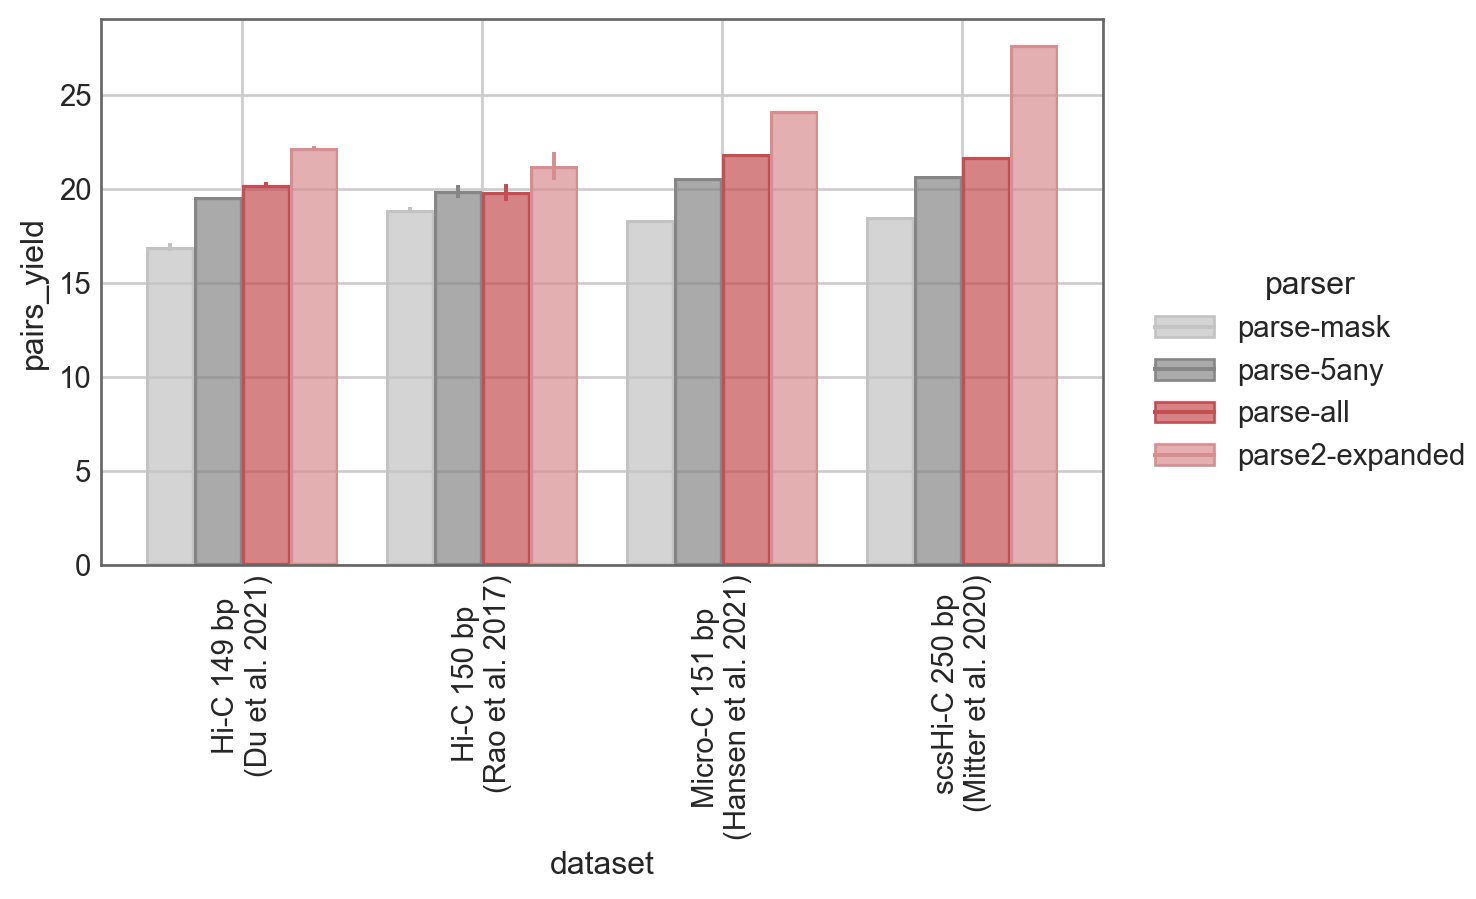

In [12]:
f = mpl.figure.Figure(figsize=[6, 5])

res = (
    so.Plot(df_final, x="dataset", y="pairs_yield", color="parser")
    .theme({**axes_style("whitegrid"), "grid.linestyle": ":", **style.library["seaborn-whitegrid"]})
    .theme({'savefig.edgecolor': '#ffffff', 'savefig.facecolor': '#ffffff', 
            'axes.edgecolor': '#666666',
          'axes.facecolor': '#ffffff', 'figure.facecolor': '#ffffff',
          'axes.prop_cycle': mpl.cycler('color', ['#D88D90', '#C44E52', '#868686', '#C3C3C3'][::-1])})
    .add(so.Bar(), so.Agg(), so.Dodge(), orient="x")
    .add(so.Range(), so.Est(errorbar="sd"), so.Dodge())
    .scale(
         order=['parse-mask', 'parse-5any', 'parse-all', 'parse2-expanded']
    )
    .on(f).plot()
)

ax = f.axes[0]
ax.tick_params(axis='x', labelrotation = 90)

f.tight_layout()

res.save("Figure2a.pdf")
res.save("Figure2a.png")

### Plot recovery

/home/agalicina/anaconda3/envs/test/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: 
The savefig.jpeg_quality rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]
/home/agalicina/anaconda3/envs/test/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: 
The savefig.jpeg_quality rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]
/home/agalicina/anaconda3/envs/test/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: 
The savefig.jpeg_quality rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]


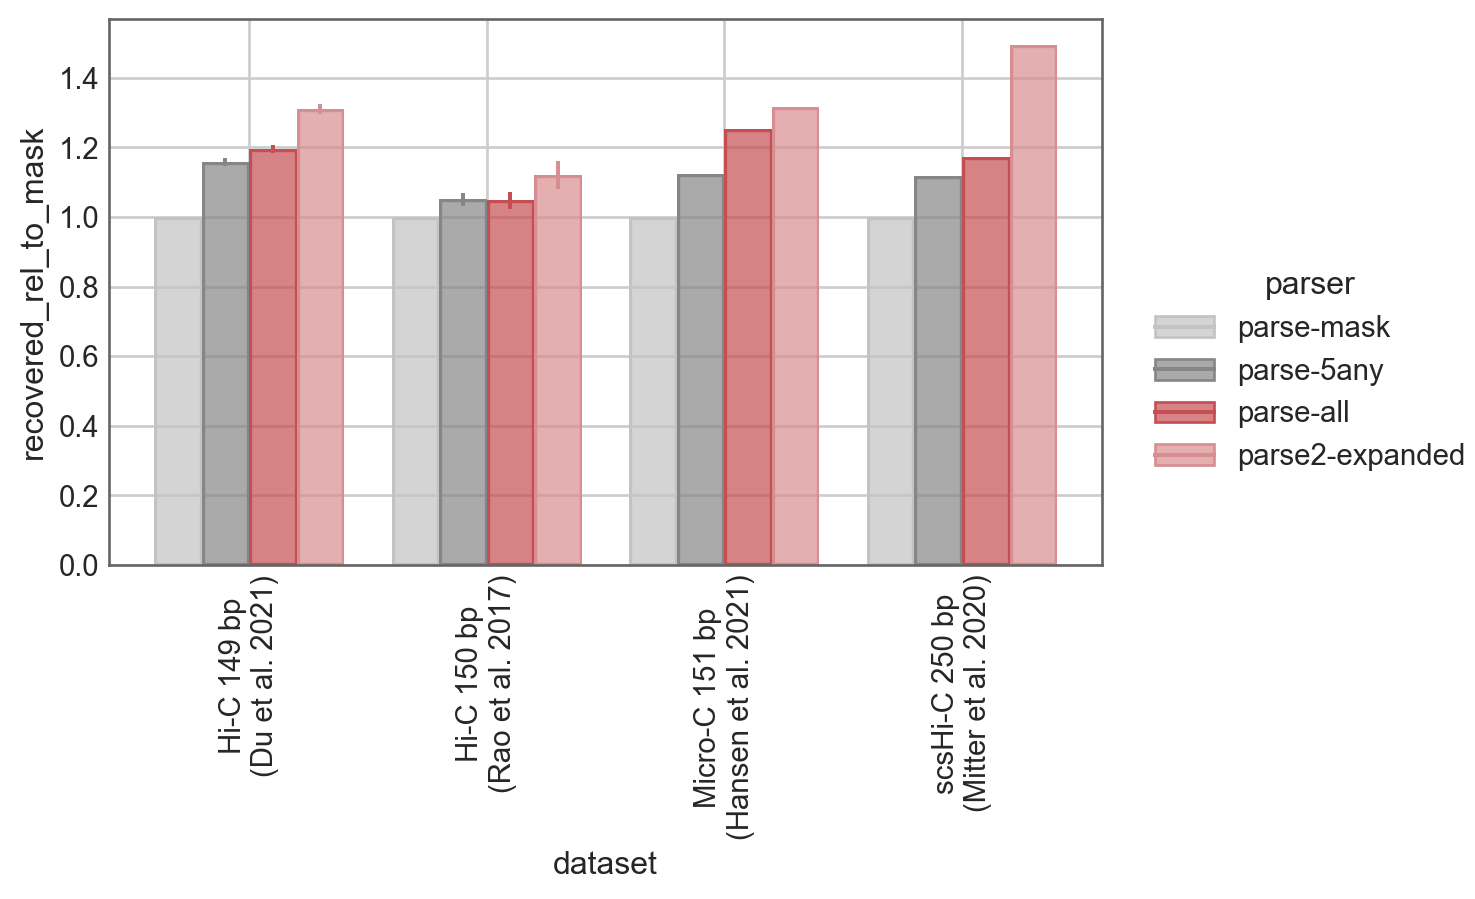

In [13]:
f = mpl.figure.Figure(figsize=[6, 5])

res = (
    so.Plot(df_final, x="dataset", y="recovered_rel_to_mask", color="parser")
    .theme({**axes_style("whitegrid"), "grid.linestyle": ":", **style.library["seaborn-whitegrid"]})
    .theme({'savefig.edgecolor': '#ffffff', 'savefig.facecolor': '#ffffff', 
            'axes.edgecolor': '#666666',
          'axes.facecolor': '#ffffff', 'figure.facecolor': '#ffffff',
          'axes.prop_cycle': mpl.cycler('color', ['#D88D90', '#C44E52', '#868686', '#C3C3C3'][::-1])})
    .add(so.Bar(), so.Agg(), so.Dodge(), orient="x")
    .add(so.Range(), so.Est(errorbar="sd"), so.Dodge())
    .scale(
        order=['parse-mask', 'parse-5any', 'parse-all', 'parse2-expanded']
    )
    .on(f).plot()
)

ax = f.axes[0]
ax.tick_params(axis='x', labelrotation = 90)

f.tight_layout()

res

res.save("Figure2a.rel-recovery.pdf")
res.save("Figure2a.rel-recovery.png")